# pCO₂ data reduction part 1: gas calibration
The first exercise is dealing with the calibration of the xCO₂ data as they are coming from the instrument.
The data are from a General Oceanics instrument, but the idea is the same for data from any instrument.   
### Remark
In the cells with python code we commented the single steps (lines starting with `#`). Please be aware that you can (and should) change certain parts of the code. You are running a copy of the original code, so you can't accidentally delete anything.

Have fun!

### Next Cell (1)
Let's start.  
The next cell just imports necessary functions, so we can perform the following calculations. Just execute it. If you want to know more about it, just ask us.

In [ ]:
# Import functions and settings used in this notebook
%run ./modules/data_reduction_modules.ipynb

## Data set
Here you find an example dataset, which was prepared for this exercise. You can download it to your computer and have a look at it:
https://fileshare.icos-cp.eu/s/wS5fnF8W9XeJHrp  
This is not needed for further calculations but you might want to know how your dataset looks. The columns are described below in the meta data section. The dataset starts with a calibration using three non-zero reference gases. The calibration is followed by nine equilibrator measurements before another calibration run is done. This one is followed again by a measuring sequence and the data file ends with a calibration. **Note:** the dataset doesn't include zero and span of the Licor. This is included in the next step.

### Here are the metadata:
**xCO2 sensor:** Licor 6262  
**xCO2 concentration of reference gases:**  

| Standard | Concentration |
| :- | -: |
| STD1 | 0 ppm |
| STD2 | 247.0 ppm | 
| STD3 | 404.9 ppm |
| STD4 | 507.8 ppm |

**column header:**

| Column | Notes |
| :- | :- |
| Timestamp | |
| Type | Type of measurement (`STDx`: standard gas x, `EQU`: equilibrator) |
| CO2 um/m | xCO₂ measurement from LI6262 in ppm |
  
In the following we will perform the calibration for this data set. The principle will be the same for any data set, no matter how long it is.

### Next cell (2)
Load the data file and display.



In [ ]:
# Load the dataset
input_data = load_file('data/part1_calibration.tsv')
input_data

### Next cell (3)
- YOU: enter the values for the reference gases
- display and plot the measurements of the first calibration run
- display a 1:1 line

In [ ]:
# concentration of reference gases
# XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
ref1 = None # Replace with the values from above
ref2 = None
ref3 = None
ref4 = None
# XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
ref_gases = [ref1, ref2, ref3, ref4]

# Define the standard run you want to work with. s1 defines the line number of teh first reference gas measurement 
# of the standard run (0, 13 or 26)
# If you come back from cell 8, remember to run all the cells in between again
# XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
s1 = 26
# XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

# Extract the set of standard measurements, and add in the reference gas values
standard_measurements = input_data[['Timestamp', 'Type', 'CO2 um/m']][s1:s1+4]
standard_measurements['Reference'] = ref_gases

# Plot the measured values vs the true concentrations
ref_vs_meas_plot = scatter_plot(standard_measurements['Reference'], standard_measurements['CO2 um/m'],
  'CO₂, referenced [ppm]', 'CO₂, measured [ppm]')

# Add a reference 1:1 line
ref_vs_meas_plot.line([-10, 550], [-10, 550], line_dash='dotted', line_color='#999999')

show(ref_vs_meas_plot)
standard_measurements


### Next cell (4)
In addition to the 1:1 line we draw a linear regression line through all measurements of this standard run in the form of
$$CO₂ (measured) = m * CO₂ (referenced) + b$$
where $m$ is the slope and $b$ is the intercept. The dotted line shows the 1:1 line, the blue dashed line the regression.

In [ ]:
#Calculate the linear regression
slope, intercept, r, p, std_err = stats.linregress(standard_measurements['Reference'],
                                                   standard_measurements['CO2 um/m'])

# We are going to store the slope and intercept for later on
original_slope = slope
original_intercept = intercept


# Plot the measured values vs the true concentrations
ref_vs_meas_plot = scatter_plot(standard_measurements['Reference'], standard_measurements['CO2 um/m'],
  'CO₂, referenced [ppm]', 'CO₂, measured [ppm]')

# Add a reference 1:1 line
line = ref_vs_meas_plot.line([-10, 550], [-10, 550], line_dash='dotted', line_color='#999999')

# Draw on the linear regression
regline = ref_vs_meas_plot.line([-10, 550], [-10 * slope + intercept, 550 * slope + intercept], line_dash='dashed')

# Print the linear regression result and draw the plot
print('CO2_meas = {: 2.4f} * CO2_cal + {: 2.2f}'.format(slope, intercept))

show(ref_vs_meas_plot)

## Note!!!
Now we have the calibrated values on the x axis and the measured values on the y axis. But we want the regression line in the way that we enter the measured values and get our "calibrated" value. There are two approaches.

## No. 1 - exchange x and y in your regression
Instead of plotting measured CO₂ vs. calibrated CO₂, one can plot calibrated vs. measured and do the regression then.

### Next cell (5)
We do the same as above but putting the measured values on the x-axis and the referenced values on the y-axis.  
Again, the dotted line shows the 1:1 line, the blue dashed line the regression.

In [ ]:
# Calculate the linear regression
slope, intercept, r, p, std_err = stats.linregress(standard_measurements['CO2 um/m'], standard_measurements['Reference'])

# Store these values for later
exchanged_slope = slope
exchanged_intercept = intercept

# Plot the true values vs the measured concentrations
meas_vs_ref_plot = scatter_plot(standard_measurements['CO2 um/m'], standard_measurements['Reference'],
  'CO₂, measured [ppm]', 'CO₂, referenced [ppm]')

# Add a reference 1:1 line
meas_vs_ref_plot.line([-10, 550], [-10, 550], line_dash='dotted', line_color='#999999')

# Draw on the linear regression
meas_vs_ref_plot.line([0, 550], [0 * slope + intercept, 550 * slope + intercept], line_dash='dashed')

# Print the linear regression result and draw the plot
print('CO2_cal = {: 2.4f} * CO2_meas + {: 2.2f}'.format(slope, intercept))
show(meas_vs_ref_plot)

## No. 2 - convert the resulting regression line
Invert the regression line mathematically. Using the form as above:  
$$CO₂ (measured) = m * CO₂ (ref) + b$$
Rearranging leads to the following:
$$CO₂ (ref) = \frac{1}{b}*CO₂ (measured) - \frac{b}{m}$$  

### Next cell (6)
Calculate the converted regression.

In [ ]:
# Calculate the linear regression as we did originally
slope, intercept, r, p, std_err = stats.linregress(standard_measurements['Reference'], standard_measurements['CO2 um/m'])

print('Original regression: CO2_meas = {: 2.4f} * CO2_cal + {: 2.2f}'.format(slope, intercept))
print('Rearrange: CO2_cal = 1 / {: 2.4f} * CO2_meas + {: 2.2f}/{: 2.4f}'.format(slope, intercept * -1, slope))

converted_slope = 1 / slope
converted_intercept = (intercept * -1) / slope

print('Solving: CO2_cal = {: 2.4f} * CO2_meas + {: 2.2f}'.format(converted_slope, converted_intercept))

## The Difference
You will notice that the exchanged regression vs the mathematically converted regression are different. It shows that the two approaches don't result in the same calibrated values. This is due to the fact that the regression is fitting ONLY in the y direction but not in x direction. We assume that the uncertainty in the reference values is negligible compared to the measured values. **Thus we need to regress measured vs. calibrated values and convert the regression coefficients.**

### Next cell (7)
Calculate the magnitude of the difference for a measurement of 400ppm:

In [ ]:
co2_value = 400
exchanged_value = co2_value * exchanged_slope + exchanged_intercept
converted_value = co2_value * converted_slope + converted_intercept
difference = abs(converted_value - exchanged_value)

print("From exchanged regression: {: 2.2f}ppm".format(exchanged_value))
print("From converted regression: {: 2.2f}ppm".format(converted_value))
print("Difference: {: 2.2f}ppm".format(difference))

## Your turn

1. Cell 3: try the different standard runs by changing the variable "s1".
2. Cell 7: calculate the resulting difference for different CO₂ values by changing the value for "co2_value".


## <span style="color: red;"> Conclusion 1 </span>  

<span style="color: red;">1. regress measured vs. referenced CO₂</span>  
<span style="color: red;">2. convert resulting slope and intercept</span>  


-----------------------------------------

# Range of standards
In the examples above we used all four reference gases (0,  247.0, 404.9, and 507.8 ppm). For most applications that means we calibrate over a huge range that is not used, as pCO₂ is not very often below 200 µatm. According to the "best practices" one should use non-zero reference gases bracketing the measured data. The zero gas is only used to zero the Licor and to check its stability.

### Next cell (8)
- Plot standards from the first standard run
- Plot regression line for using all four standards
- Plot regression line for the non-zero standards
- Show both resulting regressions


In [ ]:
# Base plot
plot = scatter_plot(standard_measurements['Reference'], standard_measurements['CO2 um/m'],
  'CO₂, measured [ppm]', 'CO₂, referenced [ppm]')

# Show the plot and its controls
print('Choose different standards to see how the regression changes (red line):')
i = interact(gascal_standard_chosen8, STD1=False, STD2=True, STD3=True, STD4=True)
handle = show(plot, notebook_handle=True)

# Draw the regression for all four standards (BLUE LINE)
gascal_plot_regression8(plot, [s1 + 0, s1 + 1, s1 + 2, s1 + 3], 'all', 'blue')

# Draw the regression for the non-zero standards (RED LINE)
gascal_plot_regression8(plot, [s1 + 1, s1 + 2, s1 + 3], 'chosen', 'red')


### Next cell (9)
- Calculate a CO₂ value from a measurement using the calibration with all standards and the one with the choosen standards 
- Calcuate the difference between the referenced value and the calculated value for all three non-zero gases using the regression with only non-zero gases 

In [ ]:
def compare_calibration(co2, STD1, STD2, STD3, STD4):
    
    # Calculate the regression for all gas standards
    all_standards = gascal_get_standard_indices(True, True, True, True)
    all_slope, all_intercept = gascal_calc_regression(all_standards)
    
    # Calculate the regression for the chosen gas standards
    chosen_standards = gascal_get_standard_indices(STD1, STD2, STD3, STD4)
    chosen_slope, chosen_intercept = gascal_calc_regression(chosen_standards)

    if len(chosen_standards) <= 1:
        print("Not enough standards chosen")
    else:
        all_calibrated = co2 * all_slope + all_intercept
        chosen_calibrated = co2 * chosen_slope + chosen_intercept
        difference = chosen_calibrated - all_calibrated
    
        print('Value when using the regression with all standards: {: 2.2f}ppm'.format(all_calibrated))
        print('Value when using the regression with the chosen standards: {: 2.2f}ppm'.format(chosen_calibrated))
        print('Difference (non-zero - all): {: 2.2f}ppm'.format(difference))
        
        
i = interact(compare_calibration, co2=widgets.IntSlider(min=250, max=800, step=1, value=400, description="CO₂ meas."), STD1=False, STD2=True, STD3=True, STD4=True)


## <span style="color: red;"> Conclusion 2 </span>  

<span style="color: red;">1. Using only non-zero standards defines the regression line better in the range of interest</span>  
<span style="color: red;">2. Bad reference gas measurements might make it necessary to include the zero gas</span>  


*-----------------------------------------*
# Interpolating standard runs
How do we apply the regression functions to our data set? An intuitive way is using the regression from our standard run at time `x` for the following measurements:  

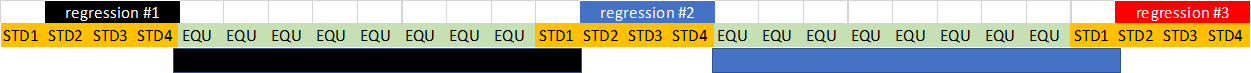




The next figure shows the measured values for the three calibration runs for STD2, STD3 and STD4 from our test data set. Between the first and the second run all measured values increased by ~1.1ppm for STD2, ~1.6ppm for STD3 and ~1ppm for STD4. This shows that we can't just use one offset value because the drift is also concentration dependent. 
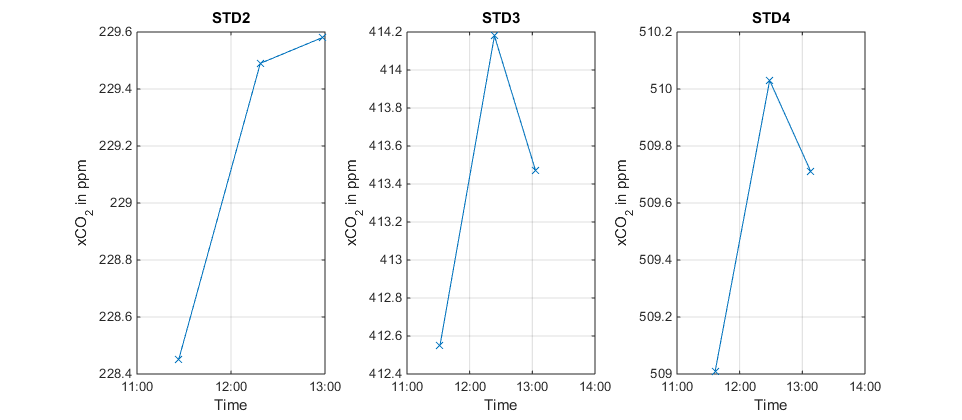

Therefore we need to interpolate the calibrations between the calibration runs. There are several methods to do that, which basically lead to the same result. Here we will interpolate the measurement of each reference gas to each measurement and have a calibration function for each single measurement. The assumption here is that the drift is linear.  
Let's do this step by step for STD2. The following figure shows the measured xCO₂ over the time (open circles). Using the values of the first two calibration runs:

11:26 - 228.45ppm  
12:18 - 229.49ppm  

this leads to $$STD2(t) = 28.717 * t + 45.01$$

where $t$ is the time of the measurement between 11:26 and 12:18. Now we can calculate a value for STD2 for each time where a measurement was taken (crosses). This is the value that we would have measured at the time $t$ when running STD2. In the next step we do the same for the next calibration runs:  

12:18 - 229.49ppm    
12:58 - 229.58ppm  

which leads to $$STD2(t) = 3.2893 * t - 25.95$$

where $t$ is the time of the measurement between 12:18 and 12:58.

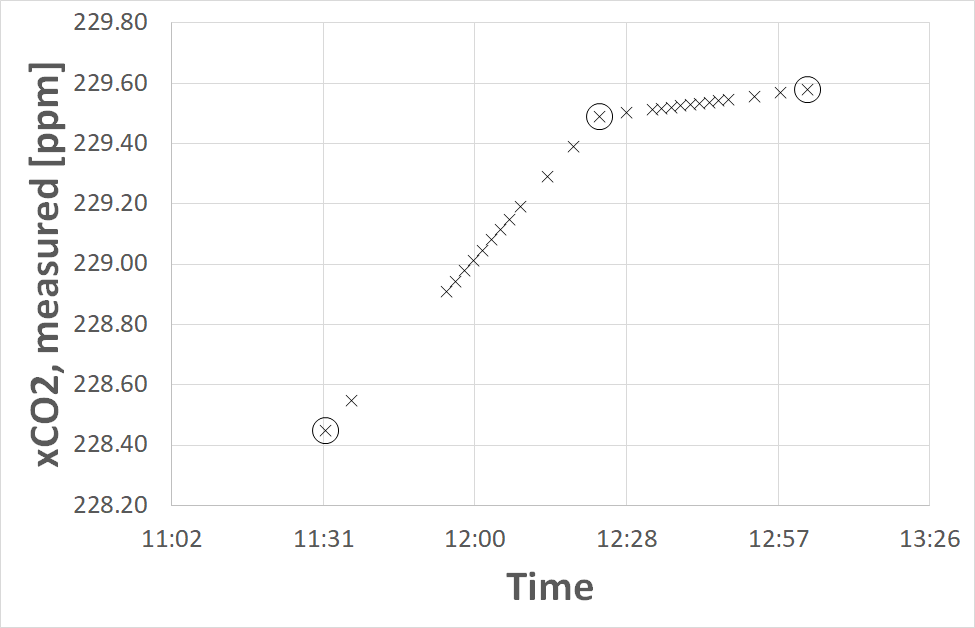

The same is done for STD3 and STD4. Thus we have a calibration function (see above) for each time where a measurement was taken.  

### Next cell (10)
Apply the interpolation decribed here to the whole data set and calculate the calibrated xCO₂.

In [ ]:
# Function to predict the measurement of one of the
# standards at a specified time
def measured_co2_at_row(standard, time):
    
    # Find the row for the required standard that is before the specified time
    # Note that there are a lot of ways to do this in Python - this is one that's easy to read.
    prior = input_data[(input_data['Type'] == standard) & (input_data['Timestamp'] < time)].iloc[-1]
    
    # Find the row for the required standard that is after the specified time
    post = input_data[(input_data['Type'] == standard) & (input_data['Timestamp'] > time)].iloc[0]
    
    # Get the times and measured values together
    
    # The times are converted to seconds
    times = [prior['Timestamp'].timestamp(), post['Timestamp'].timestamp()]
    measurements = [prior['CO2 um/m'], post['CO2 um/m']]

    # Make the linear fit
    slope, intercept, r, p, std_err = stats.linregress(times, measurements)
    
    # Calculate the value at the specified time and return it
    return time.timestamp() * slope + intercept

# Function to calibrate the CO2 value for a given row
# in the input data
def calibrate(index, row):
    
    # Calculate the measured standard values at the specified time
    std2_at_time = measured_co2_at_row('STD2', row['Timestamp'])
    std3_at_time = measured_co2_at_row('STD3', row['Timestamp'])
    std4_at_time = measured_co2_at_row('STD4', row['Timestamp'])
    
    # Perform the linear regression to the true standard concentrations
    measured_stds = [std2_at_time, std3_at_time, std4_at_time]
    true_stds = [ref2, ref3, ref4] # From cell 3
    slope, intercept, r, p, std_err = stats.linregress(measured_stds, true_stds)

    # Convert the regression
    converted_slope = 1 / slope
    converted_intercept = (intercept * -1) / slope
    
    # Calculate the calibrated CO2 and return it
    return row['CO2 um/m'] * converted_slope + converted_intercept


# The data structure for our output
calibrated_co2 = pandas.DataFrame(columns=['Timestamp', 'CO2 um/m', 'CO2 calibrated'])

# Loop through each row in the input dataset
for index, row in input_data.iterrows():
    
    # We only want to work with EQU rows
    if (row.Type) == 'EQU':

        # Extract the timestamp and measured CO2 value
        time = row['Timestamp']
        measured = row['CO2 um/m']
        
        # Run the calibration function
        calibrated = calibrate(index, row)
        
        # Add the data to the output
        new_row = {'Timestamp': time, 'CO2 um/m': measured, 'CO2 calibrated': calibrated}
        calibrated_co2 = calibrated_co2.append(new_row, ignore_index=True)


calibrated_co2


## <span style="color: red;"> Conclusion 3 </span>  

<span style="color: red;">Interpolate standard runs instead of using a constant calibration for the subsequent data</span>  

# Done!